In [1]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFECV
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
from datetime import datetime
main_start = datetime.now()
%matplotlib inline

In [2]:
raw_data = pd.read_csv('2007.csv')
list(raw_data.columns)


['Year',
 'Month',
 'DayofMonth',
 'DayOfWeek',
 'DepTime',
 'CRSDepTime',
 'ArrTime',
 'CRSArrTime',
 'UniqueCarrier',
 'FlightNum',
 'TailNum',
 'ActualElapsedTime',
 'CRSElapsedTime',
 'AirTime',
 'ArrDelay',
 'DepDelay',
 'Origin',
 'Dest',
 'Distance',
 'TaxiIn',
 'TaxiOut',
 'Cancelled',
 'CancellationCode',
 'Diverted',
 'CarrierDelay',
 'WeatherDelay',
 'NASDelay',
 'SecurityDelay',
 'LateAircraftDelay']

In [3]:
raw_data.dtypes

Year                   int64
Month                  int64
DayofMonth             int64
DayOfWeek              int64
DepTime              float64
CRSDepTime             int64
ArrTime              float64
CRSArrTime             int64
UniqueCarrier         object
FlightNum              int64
TailNum               object
ActualElapsedTime    float64
CRSElapsedTime       float64
AirTime              float64
ArrDelay             float64
DepDelay             float64
Origin                object
Dest                  object
Distance               int64
TaxiIn                 int64
TaxiOut                int64
Cancelled              int64
CancellationCode      object
Diverted               int64
CarrierDelay           int64
WeatherDelay           int64
NASDelay               int64
SecurityDelay          int64
LateAircraftDelay      int64
dtype: object

In [4]:
# Count nulls 
null_count = raw_data.isnull().sum()
null_count[null_count>0]

DepTime               160748
ArrTime               177927
TailNum                   22
ActualElapsedTime     177927
CRSElapsedTime           994
AirTime               177927
ArrDelay              177927
DepDelay              160748
CancellationCode     7292466
dtype: int64

In [5]:
#Get rid of flights that were cancelled since they couldn't be late.
df2007 = raw_data[raw_data.CancellationCode.isnull()]

#Get rid of Cancellation code since it comes up only when an aircraft is cancelled. We also won't need Year since it's 2007.
df2007 = df2007.drop(['Year', 'FlightNum', 'TailNum', 'Dest', 'Cancelled', 'Diverted', 'CancellationCode'], 1)
# Count nulls 
null_count = df2007.isnull().sum()
null_count[null_count>0]

ArrTime              17179
ActualElapsedTime    17179
CRSElapsedTime         727
AirTime              17179
ArrDelay             17179
dtype: int64

In [6]:
#Dropping out cancelled flights got rid of the majority of our nulls. The rest seem to be issues with Arrival time/delay, so let's get rid of them all. 
df2007 = df2007.dropna()
null_count = df2007.isnull().sum()
null_count[null_count>0]

Series([], dtype: int64)

In [7]:
#Turn this into a classification with the definition that a late plane is one that arrives 30 minutes or more late.
threshold = 30.0
df2007['Late'] = np.where(df2007['ArrDelay'] >= threshold, 1,0)

In [8]:
print(df2007['Late'].value_counts())

0    6177946
1    1097341
Name: Late, dtype: int64


In [9]:
airlines_ontime = df2007[df2007.Late == 0]
airlines_delay = df2007[df2007.Late == 1]

df3 = resample(airlines_ontime, n_samples=1097341)


df3 = df3.append(airlines_delay)
df3['Late'].value_counts()

1    1097341
0    1097341
Name: Late, dtype: int64

It took the following time to complete this task: 0:07:08.549795


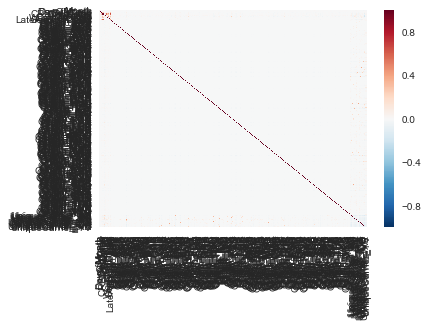

In [10]:
start = datetime.now()
# Remove some features that occur after a plane has taken off.
df3 = df3.drop(['ArrTime', 'CRSArrTime', 'ActualElapsedTime', 'CRSElapsedTime', 'AirTime'], 1)
#Turn the string features into dummies
df3 = pd.get_dummies(df3, columns=['Origin', 'UniqueCarrier'])
sns.heatmap(df3.corr())
print('It took the following time to complete this task:', datetime.now() - start)

In [11]:
X = df3.drop(['ArrDelay', 'Late'], 1)
y = df3['Late']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

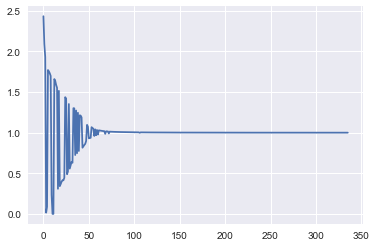

In [12]:
# Normalize the data so that all variables have a mean of 0 and standard deviation
# of 1.
X = StandardScaler().fit_transform(X_train)

# The NumPy covariance function assumes that variables are represented by rows,
# not columns, so we transpose X.
Xt = X.T
Cx = np.cov(Xt)
# Calculating eigenvalues and eigenvectors.
eig_val_cov, eig_vec_cov = np.linalg.eig(Cx)

plt.plot(eig_val_cov)
plt.show()

In [13]:
#Select features with PCA
pca = PCA(n_components=5)
X_std_pca = pca.fit_transform(X_train)
X1 = pd.DataFrame(X_std_pca)

#Now for the Test
pca = PCA(n_components=5)
X_std_pca = pca.fit_transform(X_test)
X1_test = pd.DataFrame(X_std_pca)

In [14]:
# Let's use Random Forest to select features.
start = datetime.now()
X = X_train
y = y_train
clf = RandomForestClassifier(n_estimators=1000, random_state=0, n_jobs=-1)
df2 = X.columns.get_values()
feat_labels = df2.tolist()

# Train the classifier
clf.fit(X, y)
# Create a selector object that will use the random forest classifier to identify
# features that have an importance of more than 0.15
for feature in zip(X, clf.feature_importances_):
    print(feature)

print('It took the following time to complete this task:', datetime.now() - start)

('Month', 0.0061010316332905483)
('DayofMonth', 0.0059711957343694735)
('DayOfWeek', 0.0040945433923833064)
('DepTime', 0.029957897231823696)
('CRSDepTime', 0.020784931908861649)
('DepDelay', 0.34480279922070617)
('Distance', 0.0071414633226239759)
('TaxiIn', 0.010398465802606687)
('TaxiOut', 0.049479778324953448)
('CarrierDelay', 0.12877705660662164)
('WeatherDelay', 0.022294760130636852)
('NASDelay', 0.19428126225993886)
('SecurityDelay', 0.00095056400523359837)
('LateAircraftDelay', 0.14668511129375553)
('Origin_ABE', 1.3875020199818555e-05)
('Origin_ABI', 3.9453524656133503e-06)
('Origin_ABQ', 7.2843744821940757e-05)
('Origin_ABY', 4.0783846878517609e-06)
('Origin_ACK', 2.2324949450769445e-06)
('Origin_ACT', 3.5133808844205851e-06)
('Origin_ACV', 1.635711217171827e-05)
('Origin_ACY', 4.4187384470702334e-06)
('Origin_ADK', 5.5157036898583859e-07)
('Origin_ADQ', 4.7141292587170265e-06)
('Origin_AEX', 1.0872162047495318e-05)
('Origin_AGS', 6.2701588398887095e-06)
('Origin_AKN', 2.7296

In [15]:
start = datetime.now()
sfm = SelectFromModel(clf, threshold=0.03)
rfcfeature_list =[]
# Train the selector
sfm.fit(X, y)
for feature_list_index in sfm.get_support(indices=True):
    rfcfeature_list.append(feat_labels[feature_list_index])
    print(feat_labels[feature_list_index])

X2 = X_train[rfcfeature_list]
X2_test = X_test[rfcfeature_list]
     
print('Number of features in this list: {}'.format(len(rfcfeature_list)))
print('It took the following time to complete this task:', datetime.now() - start)

DepDelay
TaxiOut
CarrierDelay
NASDelay
LateAircraftDelay
Number of features in this list: 5
It took the following time to complete this task: 1:59:34.465862


In [16]:
def testing_func(model):
    model.fit(X1, y)
    model.fit(X1_test, y_test)

    # Inspect the results.
    print('\nThe accuracy score for the Training Set with PCA:')
    print(model.score(X1, y))
    print('\nThe accuracy score for the Test Set with PCA:')
    print(model.score(X1_test, y_test))
    print('Cross Validation Scores with 10 folds for PCA: {}'.format(cross_val_score(model, X1, y, cv=10)))
    model.fit(X2, y)
    model.fit(X2_test, y_test)

    # Inspect the results.

    print('\nThe accuracy score for the Training Set with Random Forest selected features:')
    print(model.score(X2, y))
    print('\nThe accuracy score for the Test Set with Random Forest selected features:')
    print(model.score(X2_test, y_test))
    print('Cross Validation Scores with 10 folds Random Forest selected features: {}'.format(cross_val_score(model, X2, y, cv=10)))

In [17]:
start = datetime.now()
#Let's pop those into the model
lr = LogisticRegression(C=9e9)
testing_func(lr)

print('It took the following time to complete this task:', datetime.now() - start)


R-squared for the Training Set with PCA:
0.909771635403

R-squared for the Test Set with PCA:
0.909349177672
Cross Validation Scores with 10 folds for PCA: [ 0.91005035  0.90931511  0.90905881  0.9099644   0.90918359  0.90971898
  0.90978163  0.90988415  0.91162701  0.90877351]

R-squared for the Training Set with Random Forest selected features:
0.978445617103

R-squared for the Test Set with Random Forest selected features:
0.978274786587
Cross Validation Scores with 10 folds Random Forest selected features: [ 0.97836265  0.97819166  0.97822583  0.97869856  0.97832823  0.97816305
  0.97831684  0.978875    0.97853896  0.97872122]
It took the following time to complete this task: 0:03:00.678160


In [18]:
start = datetime.now()
#Let's pop those into the model
lr = LogisticRegression(C=1, penalty='l1')
testing_func(lr)

print('It took the following time to complete this task:', datetime.now() - start)


R-squared for the Training Set with PCA:
0.909772204961

R-squared for the Test Set with PCA:
0.909333230054
Cross Validation Scores with 10 folds for PCA: [ 0.91003896  0.90931511  0.90905881  0.91007262  0.9091779   0.90973607
  0.90979872  0.90988415  0.91166118  0.9087792 ]

R-squared for the Training Set with Random Forest selected features:
0.978441060632

R-squared for the Test Set with Random Forest selected features:
0.978286177743
Cross Validation Scores with 10 folds Random Forest selected features: [ 0.97786144  0.97803788  0.97731454  0.97771323  0.97773588  0.97750236
  0.97757641  0.97790675  0.97786688  0.97774727]
It took the following time to complete this task: 0:14:51.500307


In [19]:
start = datetime.now()
#Let's pop those into the model
lr = LogisticRegression(C=1, penalty='l2')
testing_func(lr)

print('It took the following time to complete this task:', datetime.now() - start)


R-squared for the Training Set with PCA:
0.909773344079

R-squared for the Test Set with PCA:
0.909349177672
Cross Validation Scores with 10 folds for PCA: [ 0.91005035  0.90931511  0.90905881  0.9099644   0.90918929  0.90971898
  0.90977593  0.90988415  0.91162131  0.90877351]

R-squared for the Training Set with Random Forest selected features:
0.978445617103

R-squared for the Test Set with Random Forest selected features:
0.978288455974
Cross Validation Scores with 10 folds Random Forest selected features: [ 0.97836265  0.97817457  0.97823152  0.97869287  0.97832823  0.97816875
  0.97831114  0.978875    0.97853896  0.97870983]
It took the following time to complete this task: 0:02:44.300297


In [20]:
start = datetime.now()
#Now let's model with Gradient Boosting
clf = GradientBoostingClassifier(loss='exponential', learning_rate=1.0, n_estimators=5, subsample=1.0, 
                                          criterion='friedman_mse', min_samples_split=4, min_samples_leaf=1, 
                                          min_weight_fraction_leaf=0.0, max_depth=2, min_impurity_decrease=0.0, 
                                          min_impurity_split=None, init=None, random_state=None, max_features=None, 
                                          verbose=0, max_leaf_nodes=None, warm_start=False, presort='auto')

testing_func(clf)

print('It took the following time to complete this task:', datetime.now() - start)


R-squared for the Training Set with PCA:
0.90489108612

R-squared for the Test Set with PCA:
0.904861062066
Cross Validation Scores with 10 folds for PCA: [ 0.90510092  0.90450235  0.90463904  0.9044397   0.90315764  0.90389238
  0.90438789  0.90410311  0.90628453  0.90438789]

R-squared for the Training Set with Random Forest selected features:
0.973017152263

R-squared for the Test Set with Random Forest selected features:
0.972902717246
Cross Validation Scores with 10 folds Random Forest selected features: [ 0.97304871  0.97250748  0.97313968  0.97331625  0.97319649  0.97248454
  0.97247884  0.97366922  0.97255858  0.97262693]
It took the following time to complete this task: 0:03:20.379238


In [21]:
start = datetime.now()
clf_1 = DecisionTreeClassifier(max_depth=5)
clf_2 = DecisionTreeClassifier(max_depth=9)
testing_func(clf_1)
testing_func(clf_2)

print('It took the following time to complete this task:', datetime.now() - start)


R-squared for the Training Set with PCA:
0.900528265779

R-squared for the Test Set with PCA:
0.900505083873
Cross Validation Scores with 10 folds for PCA: [ 0.90553379  0.90506052  0.90435426  0.90506052  0.90546436  0.90409742
  0.90529919  0.90621049  0.90721291  0.90462711]

R-squared for the Training Set with Random Forest selected features:
0.985840768449

R-squared for the Test Set with Random Forest selected features:
0.985941034818
Cross Validation Scores with 10 folds Random Forest selected features: [ 0.98491252  0.98659262  0.98617685  0.98719066  0.98537938  0.98527686
  0.98501487  0.98709946  0.98688872  0.98654698]

R-squared for the Training Set with PCA:
0.922680115848

R-squared for the Test Set with PCA:
0.924847985018
Cross Validation Scores with 10 folds for PCA: [ 0.92331526  0.92275096  0.9217998   0.92267692  0.92140636  0.92186201
  0.92193605  0.92246574  0.92357069  0.92176518]

R-squared for the Training Set with Random Forest selected features:
0.99300467

In [22]:
print('It took the following time to complete this project:', datetime.now() - main_start)

It took the following time to complete this project: 4:15:12.422788
